In [1]:

import numpy as np
import altair as alt
from tqdm import tqdm
from general_consts import *
alt.data_transformers.enable('csv')
import csv
import json
import os
import pandas as pd
from scipy import integrate
import matplotlib.pyplot as plt

# alt.renderers.enable('altair_saver', fmts=['png'])

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-1ly87ape because the default path (/home/green-sec/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def get_df(path, table_name):
    df = pd.read_csv(fr"{path}/{table_name}.csv")
    df[CPUColumns.TIME] = pd.to_datetime(df[CPUColumns.TIME], unit='s')
    df[CPUColumns.TIME] += pd.Timedelta(hours=2)
    return df

def load_tables(path):
    cpu_df = get_df(path, TableNames.CPU)
    memory_df = get_df(path, TableNames.MEMORY)
    all_processes_df = get_df(path, TableNames.ALL_PROCESSES)
    disk_df = get_df(path, TableNames.DISK)
    splunk_logs_df = pd.read_csv(fr"{path}/logs_output.csv")
    return cpu_df, memory_df, all_processes_df, disk_df, splunk_logs_df
    
def draw_plot(df, y, path, plot_name, save=True):
    chart = alt.Chart(df).mark_line(interpolate='linear').encode(
        alt.Y(f"{y}:Q", scale=alt.Scale(domain=[min(df[y]), max(df[y])])),
        alt.X(f"{CPUColumns.TIME}:T"),
    ).properties(
        width=2100,
        height=300
    )
    if save:
        # Create PNG image data and then write to a file
        with alt.data_transformers.enable('default'):
            chart.save(f"{path}/graphs/{plot_name}.png", engine="altair_saver")
    return chart

In [3]:
# tables = []
# for measurment_no in range(13,19):
#     path = fr"../../Repositories/GreenSecurity-FirstExperiment/Dell Inc. Linux 5.15.0-69-generic/Splunk Enterprise SIEM/Power Saver Plan/One Scan/Measurement {measurment_no}"
#     cpu_df, memory_df, all_processes_df, disk_df, splunk_logs_df = load_tables(path)
#     tmp = all_processes_df[(all_processes_df['PID'].isin(pids))]
#     if not tmp.empty:
#         tables.append(tmp.groupby('PID').mean())
    # cpu = draw_plot(cpu_df, CPUColumns.USED_PERCENT, path, 'cpu')
    # disc_r_c = draw_plot(disk_df, DiskIOColumns.READ_COUNT, path, 'disk_read_count')
    # disc_w_c = draw_plot(disk_df, DiskIOColumns.WRITE_COUNT, path, 'disk_write_count')
    # disc_r_b = draw_plot(disk_df, DiskIOColumns.READ_BYTES, path, 'disk_read_bytes')
    # disc_w_b = draw_plot(disk_df, DiskIOColumns.WRITE_BYTES, path, 'disk_write_bytes')
    # splunk_logs_df['_time'] = pd.to_datetime(splunk_logs_df['_time'])
    # splunk_logs_df['_time'] = splunk_logs_df['_time'].dt.tz_localize(None)

    # # Define number of bins and opacity range
    # n_bins = 200
    # logs = alt.Chart(splunk_logs_df).mark_bar(opacity=0.3, color='green').encode(
    #     alt.Y("count():Q"),
    #     alt.X("_time:T", bin=alt.Bin(maxbins=n_bins)),
    # ).properties(
    #     width=2100,
    #     height=300,
    # )
    # # Create PNG image data and then write to a file
    # with alt.data_transformers.enable('default'):
    #     logs.save(f"{path}/graphs/logs_dist.png", engine="altair_saver")
    #     alt.layer(cpu,logs).resolve_scale(
    #     y = 'independent').save(f"{path}/graphs/cpu_logs_merge.png", engine="altair_saver")
        
    #     alt.layer(disc_r_c,logs).resolve_scale(
    #     y = 'independent').save(f"{path}/graphs/disc_r_c_logs_merge.png", engine="altair_saver")
        
    #     alt.layer(disc_w_c,logs).resolve_scale(
    #     y = 'independent').save(f"{path}/graphs/disc_w_c_logs_merge.png", engine="altair_saver")
        
    #     alt.layer(disc_r_b,logs).resolve_scale(
    #     y = 'independent').save(f"{path}/graphs/disc_r_b_logs_merge.png", engine="altair_saver")
        
    #     alt.layer(disc_w_b,logs).resolve_scale(
    #     y = 'independent').save(f"{path}/graphs/disc_w_b_logs_merge.png", engine="altair_saver")
        

In [4]:
# splunk_logs_df['_time'] = pd.to_datetime(splunk_logs_df['_time']).dt.strftime('%H:%M:%S')
# Define number of bins and opacity range
# n_bins = 200
# opacity_range = [0.2, 0.8]


# chart = alt.Chart(splunk_logs_df).mark_bar(opacity=0.3, color='green').encode(
#     alt.Y("count():Q"),
#     alt.X("_time:T", bin=alt.Bin(maxbins=n_bins))
# ).properties(
#     width=2100,
#     height=300,
#     # title='Bar Chart with Adjustable Opacity'
# )
# with alt.data_transformers.enable('default'):
#     alt.layer(draw_plot(cpu_df, CPUColumns.USED_PERCENT, path, 'cpu'),chart).resolve_scale(
#         y = 'independent'
#     ).save(f"{path}/graphs/merge.png", engine="altair_saver")


In [5]:
# splunk_logs_df['_time'] = pd.to_datetime(splunk_logs_df['_time']).dt.strftime('%H:%M:%S')
# Define number of bins and opacity range
# n_bins = 200
# opacity_range = [0.2, 0.8]

# alt.layer(alt.Chart(df_pid).mark_line(interpolate='linear').encode(
#     alt.Y(f"{CPUColumns.USED_PERCENT.split(' ')[1]}:Q", scale=alt.Scale(domain=[min(df[CPUColumns.USED_PERCENT.split(' ')[1]]), max(df[CPUColumns.USED_PERCENT.split(' ')[1]])])),
#     alt.X(f"{CPUColumns.TIME}:T"),
# ).properties(
#     width=2100,
#     height=300
# ),alt.Chart(splunk_logs_df).mark_bar(opacity=0.3, color='green').encode(
# alt.Y("count():Q"),
# alt.X("_time:T", bin=alt.Bin(maxbins=n_bins))
# ).properties(
# width=2100,
# height=300,
# # title='Bar Chart with Adjustable Opacity'
# )).resolve_scale(
#     y = 'independent'
#     )


In [6]:
# alt.Chart(splunk_logs_df).mark_bar(opacity=0.3, color='green').encode(
# alt.Y("count():Q"),
# alt.X("_time:T", bin=alt.Bin(maxbins=n_bins))
# ).properties(
# width=2100,
# height=300,
# # title='Bar Chart with Adjustable Opacity'
# )

In [7]:


path = '/home/green-sec/Repositories/GreenSecurity-FirstExperiment/Dell Inc. Linux 5.15.0-70-generic/Splunk Enterprise SIEM/Power Saver Plan/One Scan'
rng = range(60, 92)
dirs = {f'Measurement {i}'for i in rng}
measurement_dirs = sorted([d for d in os.listdir(path) if d in dirs])
# measurement_dirs = sorted([d for d in os.listdir(path) if d.startswith('Measurement')])

# Load pids from json files
pids = {}
for dir_name in measurement_dirs:
    file_path = os.path.join(path, dir_name, 'pids.json')
    with open(file_path, 'r') as f:
        data = json.load(f)
        # fix it and remove!
        data_times = {}
        # for k,v in data.items():
        #     data[k] = v[1]
        #     data_times[k] = v[2]
        pids[dir_name] = data

exp_dfs = {}
for dir_name in pids:
    curr = pids[dir_name]
    data = []
    for name, [sid, pid, time, run_duration] in curr.items():
       data.append((name, sid, pid, time, run_duration)) 
    curr_df = pd.DataFrame(data, columns=['name', 'sid', 'pid', 'time', 'run_duration'])
    curr_df.name = curr_df.name.str.strip(' Clone')
    curr_df.time = pd.to_datetime(curr_df.time)
    exp_dfs[dir_name] = curr_df.sort_values('time')    

# Combine all relevant data into a single dataframe
dfs = {}
for dir_name, pid_list in pids.items():
    file_path = os.path.join(path, dir_name, 'processes_data.csv')
    df = pd.read_csv(file_path)
    df['Time(sec)'] = pd.to_datetime(df['Time(sec)'], unit='s', utc=True)
    df = df[df['PID'].isin(exp_dfs[dir_name].pid.values)].sort_values('Time(sec)') 
    df['Measurement'] = dir_name
    dfs[dir_name] = df
    
combined_df = pd.concat(dfs)

# Group by PID and calculate mean CPU
grouped_df = combined_df.groupby('PID')['CPU(%)'].mean()

print(grouped_df)


PID
2343332    4.034000
2343336    2.457143
2343339    2.455000
2343340    2.864000
2343341    2.892000
             ...   
2810611    5.017222
2810612    5.617800
2810733    5.275000
2810783    5.761373
2810835    6.017500
Name: CPU(%), Length: 896, dtype: float64


Merge when the rules running one after an other with a delay

In [8]:
# grouped_dfs = {}
# merged_dfs = {}

# from datetime import timedelta, datetime
# for measurment_name in measurement_dirs:
#     df1 = dfs[measurment_name].where(lambda x: x['Time(sec)'].dt.minute >= 1)
#     df2 = exp_dfs[measurment_name].where(lambda x: x['time'].dt.minute >= 1)
#     # merge df1 and df2 on 'pid' using a left join
#     merged_df = pd.merge(df1, df2, left_on='PID', right_on='pid', how='left')

#     # filter merged_df to keep only rows where df1['time'] is between df2['start_time'] and df2['start_time'] + 1 minute
#     merged_df = merged_df[(merged_df['Time(sec)'] >= merged_df['time']) & (merged_df['Time(sec)'] <= merged_df['time'] + timedelta(minutes=1))]

#     # drop the 'start_time' column, which is now redundant
#     merged_df = merged_df.drop(columns=['time'])
#     grouped_dfs[measurment_name] = merged_df.groupby('name').mean()
#     merged_dfs[measurment_name] = merged_df
# # concatenate the three data frames along the columns axis
# merged_df = pd.concat([x['CPU(%)'] for x in grouped_dfs.values()], axis=1)

# # compute the mean along the index axis
# mean_df = merged_df.mean(axis=1)
# mean_df = mean_df.reset_index().rename({0:'CPU(%)'}, axis=1)
# mean_df


In [9]:
# alt.Chart(mean_df).mark_bar().encode(
#         alt.Y("CPU(%):Q"),
#         alt.X(f"name:N"),
#     ).properties(
#         width=600,
#         height=300
#     )

In [10]:
# rule_chart = alt.Chart(df2).mark_rule(color='red', strokeDash=[5, 5]).encode(
#     x='time:T'
# )

# c2 = alt.Chart(merged_dfs[measurment_name]).mark_line().encode(
#         alt.Y("CPU(%):Q"),
#         alt.X(f"Time(sec):T"),
#     ).properties(
#         width=600,
#         height=300
#     )
# c2+rule_chart

Merge when all the rules running in the same time

In [11]:
relevant_processes_pid_names_grouped_dict = {}
relevant_processes_pid_names_mean_windows_dict = {}
relevant_names_inegral_dict = {}

path = fr"../../Repositories/GreenSecurity-FirstExperiment/Dell Inc. Linux 5.15.0-70-generic/Splunk Enterprise SIEM/Power Saver Plan/One Scan/"
for measurment_name in measurement_dirs:
    pid_1_times = set(exp_dfs[measurment_name].groupby('pid').count().where(lambda x: x==1).dropna().index)
    name_1_times = exp_dfs[measurment_name].where(lambda x: x.pid.isin(pid_1_times))[['name','pid']]
    relevant_processes = dfs[measurment_name].where(lambda x: x.PID.isin(pid_1_times))
    relevant_processes_pid_names = pd.merge(relevant_processes, name_1_times, left_on='PID', right_on='pid')
    
    # Get start time
    start_time = relevant_processes_pid_names['Time(sec)'].min()
    # Calculate delta time in seconds
    relevant_processes_pid_names['delta_time'] = (relevant_processes_pid_names['Time(sec)'] - start_time).dt.total_seconds()
    print(len(relevant_processes_pid_names)/relevant_processes_pid_names['delta_time'].max())
    #####Create a chart########
    # Create the dropdown menu selection
    name_selection = alt.selection_multi(fields=['name'], bind='legend')
    # Define the chart
    chart = alt.Chart(relevant_processes_pid_names).mark_line(interpolate='linear').encode(
            alt.Y("CPU(%):Q"),
            alt.X(f"delta_time:Q"),
            alt.Color('name:N', scale=alt.Scale(scheme='category20')),
            opacity=alt.condition(name_selection, alt.value(1), alt.value(0.1))
        ).properties(
            width=1500,
            height=500
        ).add_selection(name_selection).configure_legend(
            orient='bottom',
            labelLimit=10000,
            columns=4,
            labelFontSize=15
        )
    with alt.data_transformers.enable('default'):
        chart.save(f"{path}{measurment_name}/graphs/interactive_line.html")
    ##########################
    
    #####Create a chart########
    rule_chart = alt.Chart(relevant_processes_pid_names).mark_rule(strokeDash=[5, 5]).encode(
    x='min(Time(sec)):T',color='name'
    )

    c2 = alt.Chart(relevant_processes_pid_names).mark_line(interpolate='linear').encode(
            alt.Y("CPU(%):Q"),
            alt.X(f"Time(sec):T"),
        ).properties(
            width=1000,
            height=500
        )
    mean_chart = alt.Chart(relevant_processes_pid_names).mark_rule(color='red', strokeDash=[5, 5]).encode(
        y='mean(CPU(%)):Q'
    )

    chart2 = (c2+rule_chart+mean_chart).configure_legend(
                labelLimit=10000,
                labelFontSize=15
            )
    with alt.data_transformers.enable('default'):
        chart2.save(f"{path}{measurment_name}/graphs/total_cpu.html")
    ##########################
    
    relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()
    relevant_processes_pid_names_grouped_dict[measurment_name] = relevant_processes_pid_names_grouped
    #integral by name of cpu over time
    relevant_names_inegral_dict[measurment_name] = relevant_processes_pid_names.groupby('name').apply(lambda g: integrate.trapz(g['CPU(%)'], x=g['delta_time']))

    
    # # Define the time window size in minutes
    # time_window_size = 1
    # last_sec = int(np.ceil(relevant_processes_pid_names['delta_time'].max()))
    # # Create an empty column to store the mean values
    # relevant_processes_pid_names['mean_col'] = pd.Series()
    # relevant_processes_pid_names['time_window'] = pd.Series()

    # # Iterate over the time series data, and calculate the mean for each time window
    # for i in range(last_sec):
    #     start_time = i
    #     end_time = start_time + time_window_size
    #     window_data = relevant_processes_pid_names[(relevant_processes_pid_names['delta_time'] >= start_time) & (relevant_processes_pid_names['delta_time'] < end_time)]
    #     mean_values = window_data.groupby('name')['CPU(%)'].mean()
    #     for name in mean_values.index:
    #         relevant_processes_pid_names.loc[window_data[window_data['name']==name].index, 'mean_col'] = mean_values[mean_values.index==name][0]
    #         relevant_processes_pid_names.loc[window_data[window_data['name']==name].index, 'time_window'] = i
    
    relevant_processes_pid_names_mean_windows_dict[measurment_name] = relevant_processes_pid_names
    




5.161042389433962


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


6.3172514459387665


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


6.874542788766657


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


9.424821022069011


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


5.277911191690371


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


6.079319346077674


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


7.120687386747617


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


9.520194796076156


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


5.265520194959856


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


6.200416568437996


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


7.365904495387205


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


8.975485331453791


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


5.302127542991406


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


6.366822996362495


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


7.443544448913178


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


9.252567415468892


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


5.1801765381215015


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


6.082100510374204


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


7.408668987681356


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


8.948204236735965


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


5.391847379059542


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


6.049784424968574


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


7.161117188862387


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


8.987239157519811


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


5.405366062593229


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


6.080607439878755


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


6.668064088290483


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


9.027885031069937


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


5.382074283303145


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


5.804892764325229


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


7.2790313069856944


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


9.427594958054083


/tmp/ipykernel_2817648/147006204.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  relevant_processes_pid_names_grouped = relevant_processes_pid_names.groupby('name').mean()


In [12]:
durations = [60,45,30,15]
durations

[60, 45, 30, 15]

In [13]:
dirs = {f'Measurement {i}'for i in rng}
logs_len_list = []
for j,i in enumerate(rng):
    print(j)
    curr_duration = durations[j%len(durations)]
    logs = pd.read_csv(fr"{path}/{f'Measurement {i}'}/logs_output.csv")
    logs._time = pd.to_datetime(logs._time)
    logs = logs.where(lambda x: x._time.dt.hour == logs._time.dt.hour.unique().min())
    logs_len_list.append(len(logs.dropna()))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [14]:
dirs = {f'Measurement {i}'for i in rng}
integral_list = []
for j,i in enumerate(rng):
    print(j)
    curr_duration = durations[j%len(durations)]
    curr_df = relevant_processes_pid_names_mean_windows_dict[f'Measurement {i}']
    name_integral = {}
    for name in curr_df.name.unique():
        integral = integrate.simpson(curr_df[curr_df['name']==name]['CPU(%)'], x=curr_df[curr_df['name']==name]['delta_time'])
        name_integral[name] = integral
    duration_name = curr_duration
    kind = ''
    if j < len(rng)//2:
        kind = 'lite'
    else:
        kind = 'heavy'
    integral_list.append((name_integral, duration_name, f'Measurement {i}', kind, logs_len_list[j]))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [15]:
[len(x[0].keys()) for x in integral_list]

[28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28]

In [16]:
df = pd.DataFrame(integral_list, columns=['integral', 'duration', 'measurment_num', 'kind', 'logs_number'])
df

,integral,duration,measurment_num,kind,logs_number
0,{'aws_detect_iam_user_created': 12.18681418522...,60,Measurement 60,lite,47050
1,{'aws_detect_iam_user_created': 9.687518318991...,45,Measurement 61,lite,41568
2,{'aws_detect_iam_user_created': 14.30704872304...,30,Measurement 62,lite,28375
3,{'aws_detect_ec2_ssh_public_key_additi': 13.38...,15,Measurement 63,lite,11782
4,{'aws_detect_iam_new_policy_version_assignment...,60,Measurement 64,lite,47050
5,{'aws_detect_iam_user_deleted': 11.36624075656...,45,Measurement 65,lite,41555
6,{'aws_detect_ec2_ssh_public_key_additi': 11.77...,30,Measurement 66,lite,28374
7,{'aws_detect_iam_user_created': 13.53103032005...,15,Measurement 67,lite,11783
8,{'aws_detect_iam_user_created': 7.129463256315...,60,Measurement 68,lite,47050
9,{'aws_detect_ec2_ssh_public_key_additi': 13.86...,45,Measurement 69,lite,41555


In [50]:
step = 9

dirs = {f'Measurement {i}'for i in rng}
for i in rng:
    if i == step:
        break
    first_measurment = f'Measurement {i}'
    sec_measurment = f'Measurement {i+step}'
    first_relevant_processes_pid_names = relevant_processes_pid_names_mean_windows_dict[first_measurment]
    sec_relevant_processes_pid_names = relevant_processes_pid_names_mean_windows_dict[sec_measurment]
    
    rule_chart_first = alt.Chart(first_relevant_processes_pid_names).mark_rule(strokeDash=[5, 5]).encode(
        x='min(delta_time):Q',color='name'
    )

    c2_first = alt.Chart(first_relevant_processes_pid_names).mark_line(interpolate='linear').encode(
            alt.Y("CPU(%):Q"),
            alt.X(f"delta_time:Q"),
        ).properties(
            width=1000,
            height=500
        )
    mean_chart_first = alt.Chart(first_relevant_processes_pid_names).mark_rule(color='blue', strokeDash=[5, 5]).encode(
        y='mean(CPU(%)):Q'
    )
    rule_chart_sec = alt.Chart(sec_relevant_processes_pid_names).mark_rule(strokeDash=[5, 5]).encode(
        x='min(delta_time):Q',color='name'
    )

    c2_sec = alt.Chart(sec_relevant_processes_pid_names).mark_line(color='red',interpolate='linear').encode(
            alt.Y("CPU(%):Q"),
            alt.X(f"delta_time:Q"),
        ).properties(
            width=1000,
            height=500
        )
    mean_chart_sec = alt.Chart(sec_relevant_processes_pid_names).mark_rule(color='red', strokeDash=[5, 5]).encode(
        y='mean(CPU(%)):Q'
    )
    with alt.data_transformers.enable('default'):
        (c2_first+rule_chart_first+mean_chart_first+c2_sec+rule_chart_sec+mean_chart_sec).configure_legend(
                labelLimit=10000,
                labelFontSize=15
            ).save(f"{path}{measurment_name}/graphs/compare_cpu.html")

In [64]:
# create histogram with mean rule
hist = alt.Chart(first_relevant_processes_pid_names).mark_bar(color='red', opacity=0.2).encode(
    alt.X('CPU(%)', bin=alt.Bin(step=0.2)),
    y='count()'
)

mean_rule = alt.Chart(first_relevant_processes_pid_names).mark_rule(color='red').encode(
    x='mean(CPU(%))'
)
# create histogram with mean rule
hist_sec = alt.Chart(sec_relevant_processes_pid_names).mark_bar(color='green', opacity=0.2).encode(
    alt.X('CPU(%)', bin=alt.Bin(step=0.2)),
    y='count()'
)

mean_rule_sec = alt.Chart(sec_relevant_processes_pid_names).mark_rule(color='green').encode(
    x='mean(CPU(%))'
)

# combine the two charts
# combine the two charts and add a legend
chart = alt.layer(hist, mean_rule, hist_sec, mean_rule_sec).properties(
    title='Histogram of CPU',
    width=500,
    height=300
)
chart.configure_axis(
    gridOpacity=0.5
).configure_view(
    strokeWidth=0
).configure_title(
    fontSize=20,
    fontWeight='bold'
).configure_legend(
    title=None,
    labelFontSize=15
)


alt.LayerChart(...)

In [ ]:
relevant_processes_pid_names.apply(lambda g: integrate.trapz(g['CPU(%)'], x=g['delta_time']))


In [210]:
# concatenate the three data frames along the columns axis
merged_df_line = pd.concat([x.groupby(['name','time_window'])[['mean_col']].mean() for x in relevant_processes_pid_names_mean_windows_dict.values()], axis=1)
durations = range(60, 0, -15)
num_of_different_durations = len([x for x in durations])
# select even and odd columns from the 'CPU(%)' columns
mean_std_df_line = pd.concat([merged_df_line.iloc[:, i::num_of_different_durations].agg(['mean', 'std'], axis=1).add_suffix('_'+str(durations[i])) for i in range(num_of_different_durations)], axis=1)
# mean_std_df.iloc[:, 0:2].columns = mean_std_df.iloc[:, 0:2].add_suffix('_odd').columns
# mean_std_df.iloc[:, 2:4].columns = mean_std_df.iloc[:, 2:4].add_suffix('_even').columns
# print the final dataframe
# mean_std_df_line.fillna(0, inplace=True)
mean_std_df_line


KeyError: 'time_window'

In [24]:
mean_std_df_line.loc['aws_detect_cloud_infrastructure_discovery_via_golang_smogcloud']

,mean_60,std_60,mean_45,std_45,mean_30,std_30,mean_15,std_15
time_window,,,,,,,,
0.0,10.0625,1.566242,6.775,0.480833,10.0975,1.651094,3.3700,0.304056
1.0,11.2550,3.104199,6.735,1.859691,11.2650,3.372899,5.7650,0.014142
3.0,13.6400,NaN,8.040,0.551543,15.9900,1.414214,7.5400,1.442498
4.0,14.0200,1.046518,9.205,1.067731,13.1150,0.742462,7.1800,1.046518
5.0,10.7050,0.841457,14.035,0.700036,11.0000,1.979899,12.5500,0.989949
6.0,12.6000,2.404163,9.075,0.799031,11.5450,1.831407,7.9025,1.149049
8.0,12.6750,1.661701,6.330,0.777817,14.4225,0.583363,6.8300,2.432447
9.0,18.2900,NaN,12.435,1.944544,13.6750,3.302189,8.7250,1.506137
10.0,13.1500,1.046518,13.850,NaN,9.1100,1.527351,6.4800,0.113137


In [29]:
mean_std_df_line

mean_60  \
name                                               time_window            
aws_detect_cloud_infrastructure_discovery_via_g... 0.0          10.0625   
                                                   1.0          11.2550   
                                                   3.0          13.6400   
                                                   4.0          14.0200   
                                                   5.0          10.7050   
...                                                                 ...   
aws_detect_s3_cloudtrail_bucket_lifecycle_rule_... 22.0             NaN   
                                                   23.0             NaN   
                                                   24.0             NaN   
                                                   25.0             NaN   
                                                   26.0             NaN   

                                                                  std_60  \
name                                               time_window             
aws_detect_cloud_infrastructure_discovery_via_g... 0.0          1.566242   
                                                   1.0          3.104199   
                                                   3.0               NaN   
                                                   4.0          1.046518   
                                                   5.0          0.841457   
...                                                                  ...   
aws_detect_s3_cloudtrail_bucket_lifecycle_rule_... 22.0              NaN   
                                                   23.0              NaN   
                                                   24.0              NaN   
                                                   25.0              NaN   
                                                   26.0              NaN   

                                                                mean_45  \
name                                               time_window            
aws_detect_cloud_infrastructure_discovery_via_g... 0.0            6.775   
                                                   1.0            6.735   
                                                   3.0            8.040   
                                                   4.0            9.205   
                                                   5.0           14.035   
...                                                                 ...   
aws_detect_s3_cloudtrail_bucket_lifecycle_rule_... 22.0             NaN   
                                                   23.0             NaN   
                                                   24.0             NaN   
                                                   25.0             NaN   
                                                   26.0             NaN   

                                                                  std_45  \
name                                               time_window             
aws_detect_cloud_infrastructure_discovery_via_g... 0.0          0.480833   
                                                   1.0          1.859691   
                                                   3.0          0.551543   
                                                   4.0          1.067731   
                                                   5.0          0.700036   
...                                                                  ...   
aws_detect_s3_cloudtrail_bucket_lifecycle_rule_... 22.0              NaN   
                                                   23.0              NaN   
                                                   24.0              NaN   
                                                   25.0              NaN   
                                                   26.0              NaN   

                                                                mean_30  \
name                                               time_win

In [25]:
mean_df_line = mean_std_df_line[[x for x in mean_std_df_line.columns if x.startswith('mean')]].reset_index().melt(var_name='duration',id_vars='time_window')
std_df_line =mean_std_df_line[[x for x in mean_std_df_line.columns if x.startswith('std')]].reset_index().melt(var_name='duration',id_vars='time_window')
mean_df_line[['kind', 'duration']] = mean_df_line.duration.str.split('_', expand=True)
std_df_line[['kind', 'duration']] = std_df_line.duration.str.split('_', expand=True)

In [26]:
df_merged_mean_std = pd.merge(mean_df_line, std_df_line, on=['time_window', 'duration'])
df_merged_mean_std

,time_window,duration,value_x,kind_x,value_y,kind_y
0,0.0,None,aws_detect_cloud_infrastructure_discovery_via_...,name,aws_detect_cloud_infrastructure_discovery_via_...,name
1,0.0,None,aws_detect_cloud_infrastructure_discovery_via_...,name,aws_detect_cloudwatch_log_stream_delet,name
2,0.0,None,aws_detect_cloud_infrastructure_discovery_via_...,name,aws_detect_guardduty_archive_findings,name
3,0.0,None,aws_detect_cloud_infrastructure_discovery_via_...,name,aws_detect_guardduty_disab,name
4,0.0,None,aws_detect_cloud_infrastructure_discovery_via_...,name,aws_detect_iam_accesskey_created,name
...,...,...,...,...,...,...
484995,228.0,15,NaN,mean,NaN,std
484996,228.0,15,NaN,mean,NaN,std
484997,228.0,15,NaN,mean,NaN,std
484998,228.0,15,NaN,mean,NaN,std


In [27]:
# reshape dataframe using pivot
df_pivot = df_merged_mean_std.pivot(index=['time_window', 'duration'], columns=['kind_x','kind_y'], values=['value_x', 'value_y']).reset_index()

# rename columns
df_pivot.columns = ['time_window', 'duration', 'mean', 'std']

print(df_pivot)

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
df_pivot['minus_std'] = df_pivot['mean'] + (-1) * df_pivot['std']
df_pivot['pluse_std'] = df_pivot['mean'] + df_pivot['std']

In [ ]:
name_selection = alt.selection_multi(fields=['duration'], bind='legend')
lines = alt.Chart(df_pivot).mark_line().encode(
            alt.Y("mean:Q",title='Mean CPU(%)'),
            alt.X(f"time_window:Q"),
            alt.Color('duration:N'),
            opacity=alt.condition(name_selection, alt.value(1), alt.value(0.1)),
        ).transform_filter(
    'isValid(datum.mean)'
)

# Create the shaded area for the standard deviation
band = alt.Chart(df_pivot).mark_errorband().encode(
    alt.Y("pluse_std:Q"),
    alt.Y2("minus_std:Q"),
    alt.X(f"time_window:Q"),
    alt.Color('duration:N'),
    opacity=alt.condition(name_selection, alt.value(0.2), alt.value(0.02)),
    # yError="std:Q"
)
final_chart = (lines + band).properties(
            width=1500,
            height=500,
            title="Mean and Std CPU usage along the time over 4 duration"
        ).add_selection(name_selection).configure_legend(
            labelLimit=10000,
            columns=4,
            labelFontSize=15
        )

In [ ]:
final_chart

alt.LayerChart(...)

In [ ]:
with alt.data_transformers.enable('default'):
    final_chart.save(f"interactive_line_all.html")

Merge when all the experiments were ran for the same duration

In [56]:
# concatenate the three data frames along the columns axis
merged_df = pd.concat([x[['CPU(%)']] for x in relevant_processes_pid_names_grouped_dict.values()], axis=1)

# compute the mean along the index axis
mean_std_df = merged_df.agg(['mean', 'std'],axis=1)
print(f"Num of rules: {len(mean_std_df)}")
mean_std_df

Num of rules: 34


,mean,std
name,,
aws_detect_cloud_infrastructure_discovery_via_golang_smogcloud,7.385345,3.001688
aws_detect_cloudtrail_trail_deleted,4.908582,0.907910
aws_detect_ec2_ssh_public_key_additi,3.690361,1.596065
aws_detect_ecr_image_auth_token_get,4.935161,0.602113
aws_detect_ecr_new_repo_image_creat,4.599001,2.415157
aws_detect_guardduty_suppression_filter_creati,4.808620,0.555601
aws_detect_iam_default_policy_version_set,4.875792,0.536076
aws_detect_iam_group_added_with_user,4.746149,0.354116
aws_detect_iam_group_added_with_user_from_ec2,3.754760,0.935747


Merge between the same duration

In [59]:
# concatenate the three data frames along the columns axis
merged_df = pd.concat([x[['CPU(%)']] for x in relevant_processes_pid_names_grouped_dict.values()], axis=1)
num_of_different_durations = len([x for x in durations])
# select even and odd columns from the 'CPU(%)' columns
mean_std_df = pd.concat([merged_df.iloc[:, i::num_of_different_durations].agg(['mean', 'std'], axis=1).add_suffix('_'+str(durations[i])) for i in range(num_of_different_durations)], axis=1)
# mean_std_df.iloc[:, 0:2].columns = mean_std_df.iloc[:, 0:2].add_suffix('_odd').columns
# mean_std_df.iloc[:, 2:4].columns = mean_std_df.iloc[:, 2:4].add_suffix('_even').columns
# print the final dataframe
mean_std_df


,mean_60,std_60,mean_40,std_40,mean_20,std_20
name,,,,,,
aws_detect_cloud_infrastructure_discovery_via_golang_smogcloud,7.188084,NaN,6.031907,0.116042,7.869368,3.659492
aws_detect_cloudtrail_trail_deleted,NaN,NaN,4.273285,0.135183,5.120348,0.967011
aws_detect_ec2_ssh_public_key_additi,NaN,NaN,2.813000,1.098987,4.567722,1.688639
aws_detect_ecr_image_auth_token_get,NaN,NaN,4.248448,NaN,5.049613,0.570100
aws_detect_ecr_new_repo_image_creat,NaN,NaN,4.248519,3.443149,4.949484,1.535795
aws_detect_guardduty_suppression_filter_creati,NaN,NaN,4.144418,0.203213,5.030021,0.434307
aws_detect_iam_default_policy_version_set,NaN,NaN,4.240768,NaN,4.981630,0.500759
aws_detect_iam_group_added_with_user,NaN,NaN,4.473253,NaN,4.791632,0.364830
aws_detect_iam_group_added_with_user_from_ec2,NaN,NaN,3.197937,0.631245,4.311583,0.927593


/home/green-sec/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/green-sec/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/green-sec/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/green-sec/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


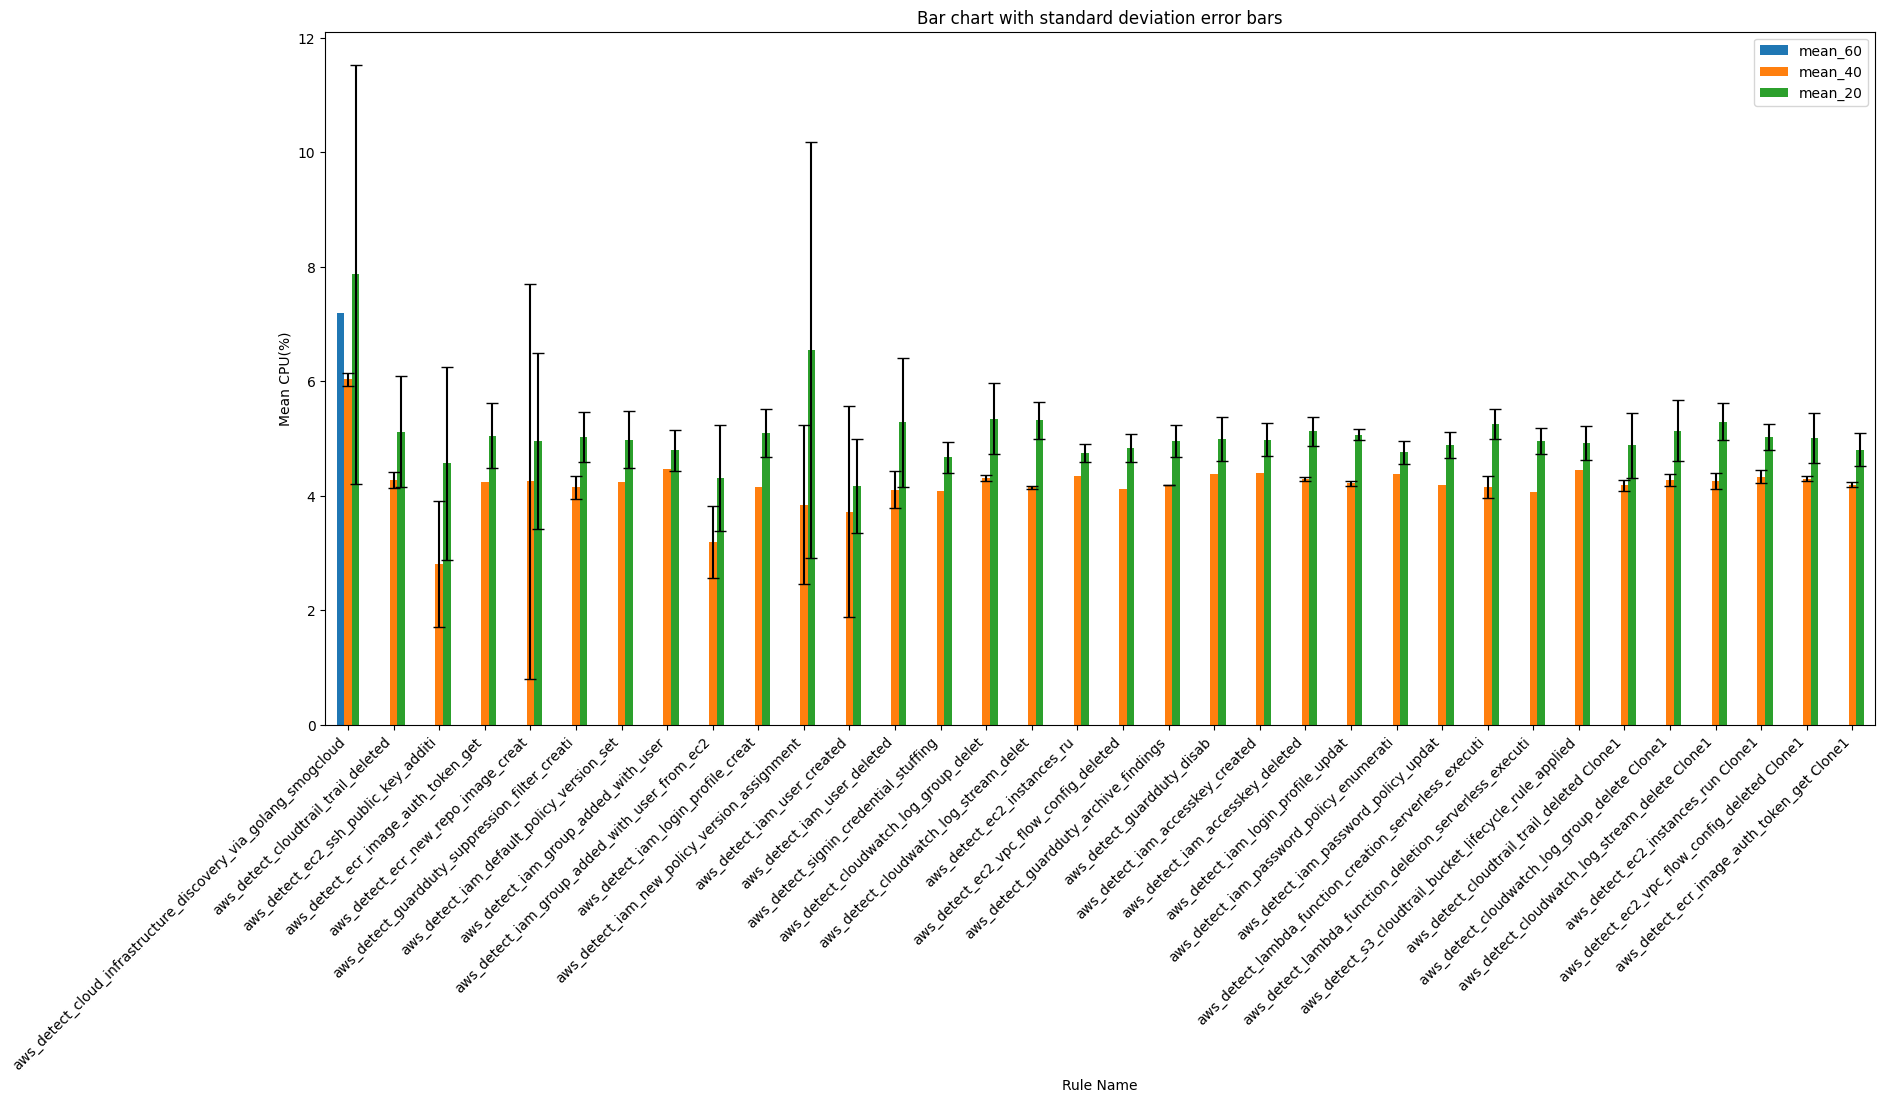

In [60]:
# Set up the figure
# fig, ax = plt.subplots()
# df_to_plot = mean_std_df.reset_index().fillna(0)
# df_to_plot['std_15'] = df_to_plot['std_15'].astype(float)
# df_to_plot['std_30'] = df_to_plot['std_30'].astype(float)
# Plot the bars with error bars
mean_cols = [f"mean_{i}" for i in durations]
std_cols = [f"std_{i}" for i in durations]
ax = mean_std_df.reset_index()[["name"]+mean_cols].plot(x="name", yerr=mean_std_df[std_cols].T.values, kind="bar",capsize=4, rot=0, figsize=(20,9))
# ax.bar(mean_std_df.reset_index()['name'], mean_std_df.reset_index()[['mean_0','mean_1']], capsize=5)
# plt.rcParams["figure.figsize"] = (20, 9)
# Add axis labels and title
ax.set_xlabel('Rule Name')
ax.set_ylabel('Mean CPU(%)')
ax.set_title('Bar chart with standard deviation error bars')
# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


In [33]:
relevant_processes_pid_names.groupby('name').apply(lambda g: integrate.trapz(g['CPU(%)'], x=g['delta_time']))

name
aws_detect_cloud_infrastructure_discovery_via_golang_smogcloud     85.645589
aws_detect_cloudtrail_trail_deleted                               190.889230
aws_detect_cloudtrail_trail_deleted Clone1                        175.880056
aws_detect_cloudwatch_log_group_delet                             184.182796
aws_detect_cloudwatch_log_group_delete Clone1                     188.183938
aws_detect_cloudwatch_log_stream_delet                            190.663417
aws_detect_cloudwatch_log_stream_delete Clone1                    177.957377
aws_detect_ec2_instances_ru                                       188.918290
aws_detect_ec2_instances_run Clone1                               172.879125
aws_detect_ec2_vpc_flow_config_deleted                            193.306609
aws_detect_ec2_vpc_flow_config_deleted Clone1                     168.591886
aws_detect_ecr_image_auth_token_get                               190.167729
aws_detect_ecr_image_auth_token_get Clone1                        175.5

In [34]:
relevant_processes_pid_names.values

array([[Timestamp('2023-05-26 08:00:01.287491072+0000', tz='UTC'),
        1600227, 'splunkd', ..., 0.0, 5.3149999999999995, 0.0],
       [Timestamp('2023-05-26 08:00:01.721647616+0000', tz='UTC'),
        1600227, 'splunkd', ..., 0.434156544, 5.3149999999999995, 0.0],
       [Timestamp('2023-05-26 08:00:02.300158464+0000', tz='UTC'),
        1600227, 'splunkd', ..., 1.012667392, 5.205, 1.0],
       ...,
       [Timestamp('2023-05-26 08:01:20.945903104+0000', tz='UTC'),
        1602259, 'splunkd', ..., 79.658412032, 12.563333333333333, 79.0],
       [Timestamp('2023-05-26 08:01:21.228608512+0000', tz='UTC'),
        1602259, 'splunkd', ..., 79.94111744, 12.563333333333333, 79.0],
       [Timestamp('2023-05-26 08:01:21.459412224+0000', tz='UTC'),
        1602259, 'splunkd', ..., 80.171921152, 12.39, 80.0]], dtype=object)

In [208]:
# concatenate the three data frames along the columns axis
merged_df = pd.concat([x for x in relevant_names_inegral_dict.values()], axis=1)
durations = range(60, 0, -15)
num_of_different_durations = len([x for x in durations])
# select even and odd columns from the 'CPU(%)' columns
mean_std_df = pd.concat([merged_df.iloc[:, i::num_of_different_durations].agg(['mean', 'std'], axis=1).add_suffix('_'+str(durations[i])) for i in range(num_of_different_durations)], axis=1)
# mean_std_df.iloc[:, 0:2].columns = mean_std_df.iloc[:, 0:2].add_suffix('_odd').columns
# mean_std_df.iloc[:, 2:4].columns = mean_std_df.iloc[:, 2:4].add_suffix('_even').columns
# print the final dataframe
mean_std_df

,mean_60,std_60,mean_45,std_45,mean_30,std_30,mean_15,std_15
name,,,,,,,,
aws_detect_cloud_infrastructure_discovery_via_golang_smogcloud,284.934713,7.488787,259.679581,4.740275,182.899536,4.052308,88.160479,3.340207
aws_detect_cloudtrail_trail_deleted,633.769586,22.010267,566.984408,12.913281,399.626882,11.741613,177.941382,5.086277
aws_detect_cloudwatch_log_group_delet,639.274455,18.524932,576.869573,14.072719,401.163538,15.871198,178.890194,6.387596
aws_detect_cloudwatch_log_stream_delet,645.960742,19.744867,572.971764,12.458126,401.758226,11.582111,175.743883,5.683237
aws_detect_ec2_instances_ru,643.736046,25.508597,575.969210,11.721813,394.995877,9.978847,175.574242,6.994183
aws_detect_ec2_ssh_public_key_additi,8.610929,2.482472,12.921231,1.764823,11.857954,0.608548,13.844327,0.866103
aws_detect_ec2_vpc_flow_config_deleted,635.312690,15.978231,562.886944,8.068153,395.726782,14.142682,179.965578,6.927001
aws_detect_ecr_image_auth_token_get,639.166632,18.465850,576.062419,7.056751,396.458415,13.560809,177.507925,6.052264
aws_detect_ecr_new_repo_image_creat,7.933546,3.047747,12.626105,1.190432,12.498617,1.059356,13.824737,1.260729


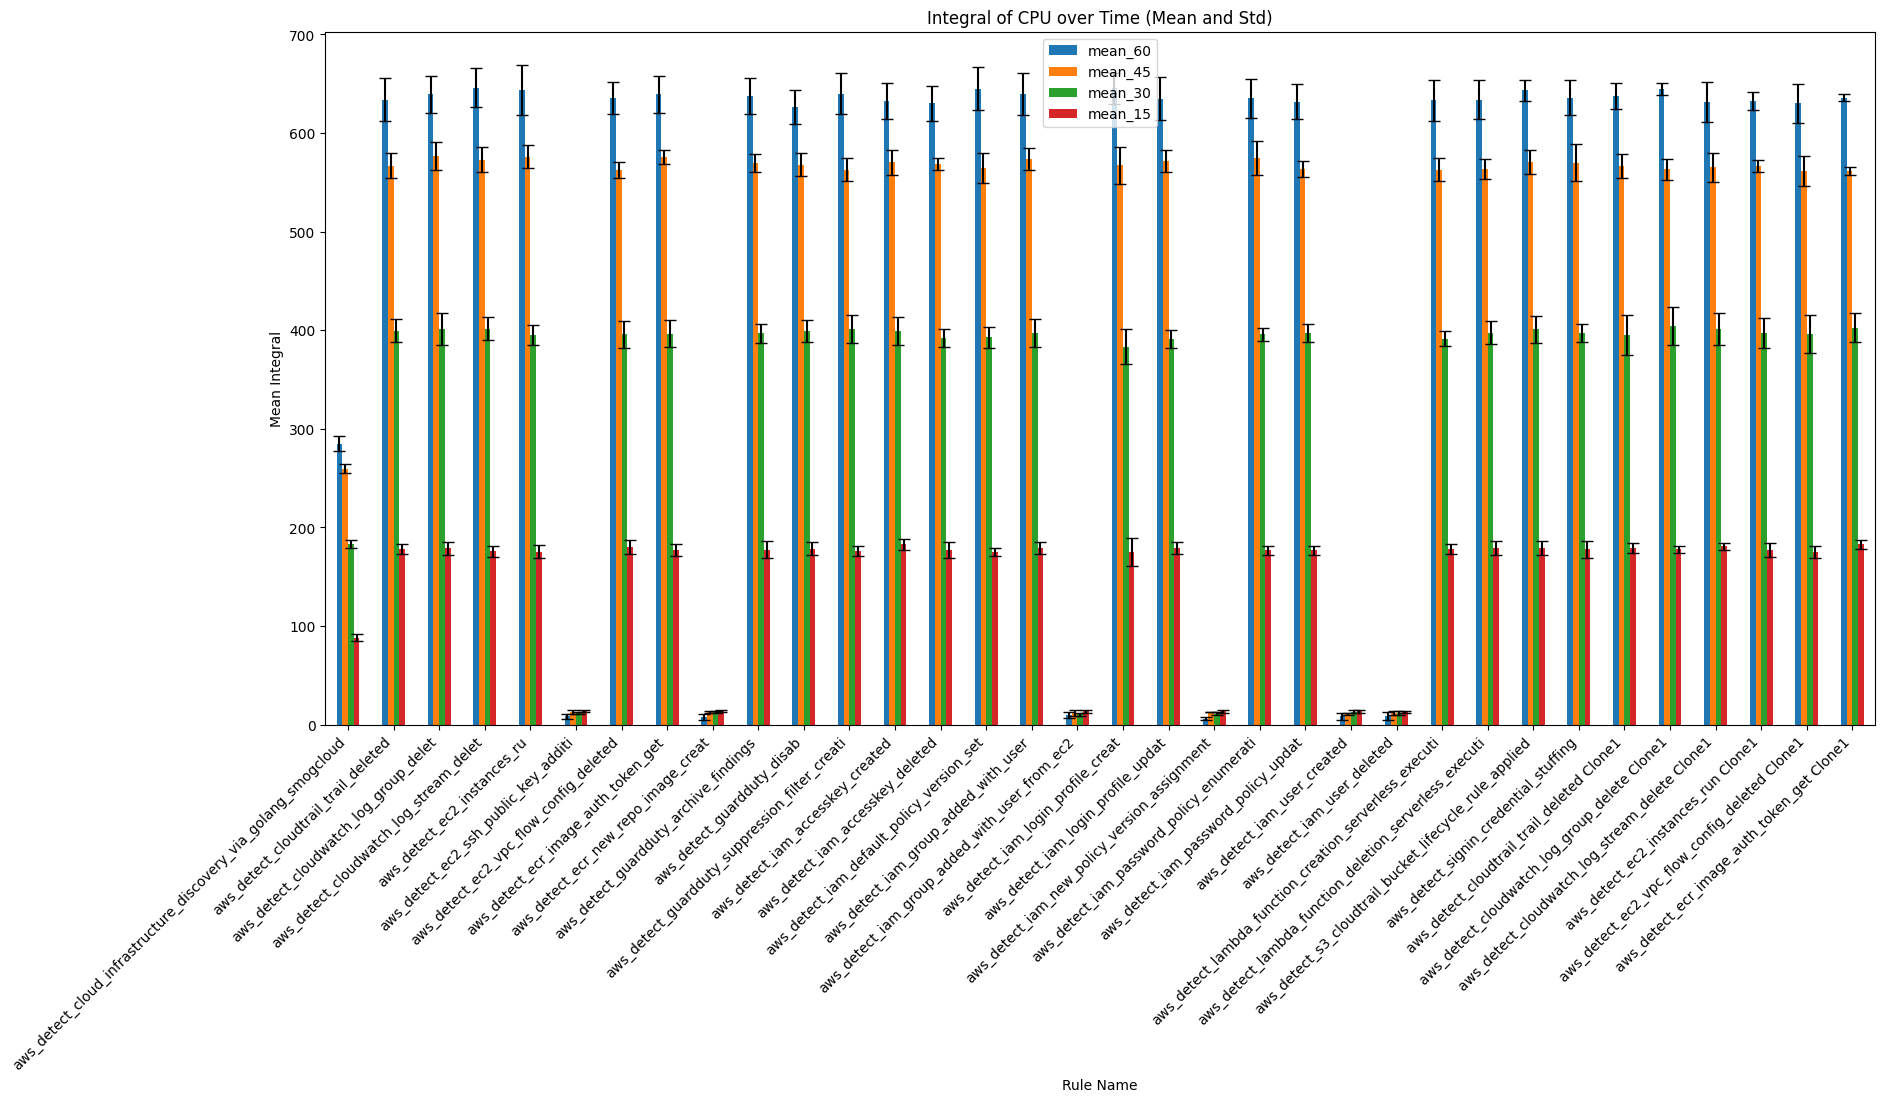

In [209]:

# Set up the figure
# fig, ax = plt.subplots()
# df_to_plot = mean_std_df.reset_index().fillna(0)
# df_to_plot['std_15'] = df_to_plot['std_15'].astype(float)
# df_to_plot['std_30'] = df_to_plot['std_30'].astype(float)
# Plot the bars with error bars
mean_cols = [f"mean_{i}" for i in durations]
std_cols = [f"std_{i}" for i in durations]
ax = mean_std_df.reset_index()[["name"]+mean_cols].plot(x="name", yerr=mean_std_df[std_cols].T.values, kind="bar", rot=0, capsize=4, figsize=(20,9))
# ax.bar(mean_std_df.reset_index()['name'], mean_std_df.reset_index()[['mean_0','mean_1']], capsize=5)
# plt.rcParams["figure.figsize"] = (20, 9)
# Add axis labels and title
ax.set_xlabel('Rule Name')
ax.set_ylabel('Mean Integral')
ax.set_title('Integral of CPU over Time (Mean and Std)')
# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [17]:
sum_df = df
sum_df['sum_integral'] = df.integral.apply(lambda x: sum(x.values()))

In [18]:
sum_df

,integral,duration,measurment_num,kind,logs_number,sum_integral
0,{'aws_detect_iam_user_created': 12.18681418522...,60,Measurement 60,lite,47050,14064.272380
1,{'aws_detect_iam_user_created': 9.687518318991...,45,Measurement 61,lite,41568,12101.664815
2,{'aws_detect_iam_user_created': 14.30704872304...,30,Measurement 62,lite,28375,8768.374848
3,{'aws_detect_ec2_ssh_public_key_additi': 13.38...,15,Measurement 63,lite,11782,4036.632848
4,{'aws_detect_iam_new_policy_version_assignment...,60,Measurement 64,lite,47050,13643.300810
5,{'aws_detect_iam_user_deleted': 11.36624075656...,45,Measurement 65,lite,41555,12238.875823
6,{'aws_detect_ec2_ssh_public_key_additi': 11.77...,30,Measurement 66,lite,28374,8555.791894
7,{'aws_detect_iam_user_created': 13.53103032005...,15,Measurement 67,lite,11783,3860.564845
8,{'aws_detect_iam_user_created': 7.129463256315...,60,Measurement 68,lite,47050,13595.105590
9,{'aws_detect_ec2_ssh_public_key_additi': 13.86...,45,Measurement 69,lite,41555,12169.342975


In [149]:
df_group = sum_df.groupby(['duration','kind']).agg(['mean','std'])
df_group.columns = df_group.columns.to_flat_index()
df_group = df_group.reset_index()
df_group.columns = ['duration', 'kind','logs_number_mean','logs_number_std','sum_integral_mean','sum_integral_std']
df_group

/tmp/ipykernel_2817648/3215586396.py:1: FutureWarning: ['integral', 'measurment_num'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_group = sum_df.groupby(['duration','kind']).agg(['mean','std'])


,duration,kind,logs_number_mean,logs_number_std,sum_integral_mean,sum_integral_std
0,15,heavy,14251.00,4938.000000,4916.135811,63.494202
1,15,lite,11782.75,0.500000,3873.857555,116.183672
2,30,heavy,28374.25,0.500000,10944.378467,212.974311
3,30,lite,28374.25,0.500000,8523.165455,204.750306
4,45,heavy,41240.50,363.156991,15625.079573,78.695182
5,45,lite,41561.50,7.505553,12230.675894,133.727692
6,60,heavy,47050.00,0.000000,17452.473459,440.039671
7,60,lite,47050.00,0.000000,13740.101700,217.766188


In [150]:
df_group['logs_number_std2'] = df_group['logs_number_mean']-df_group.logs_number_std/2
df_group['logs_number_std'] = df_group['logs_number_mean']+df_group.logs_number_std/2
df_group['sum_integral_std2'] = df_group['sum_integral_mean']-df_group.sum_integral_std/2
df_group['sum_integral_std'] = df_group['sum_integral_mean']+df_group.sum_integral_std/2
df_group

,duration,kind,logs_number_mean,logs_number_std,sum_integral_mean,sum_integral_std,logs_number_std2,sum_integral_std2
0,15,heavy,14251.00,16720.000000,4916.135811,4947.882912,11782.000000,4884.388710
1,15,lite,11782.75,11783.000000,3873.857555,3931.949391,11782.500000,3815.765719
2,30,heavy,28374.25,28374.500000,10944.378467,11050.865623,28374.000000,10837.891312
3,30,lite,28374.25,28374.500000,8523.165455,8625.540608,28374.000000,8420.790302
4,45,heavy,41240.50,41422.078495,15625.079573,15664.427164,41058.921505,15585.731981
5,45,lite,41561.50,41565.252777,12230.675894,12297.539740,41557.747223,12163.812048
6,60,heavy,47050.00,47050.000000,17452.473459,17672.493295,47050.000000,17232.453624
7,60,lite,47050.00,47050.000000,13740.101700,13848.984794,47050.000000,13631.218606


In [207]:
line = alt.Chart(df_group).mark_line(point=True).encode(
            alt.Y("sum_integral_mean:Q",title='Mean CPU(%) Integral over Time'),
            alt.X(f"logs_number_mean:Q",title='Mean ingested logs quantity'),
            alt.Color('kind:N'),
        ).properties(
    width=1000,
    height=400,
    title='Mean over 8 measurments'
)
line

alt.Chart(...)

In [199]:
x

,logs_number_mean,logs_number_std,heavy_sum_integral_mean,heavy_sum_integral_std,lite_sum_integral_mean,lite_sum_integral_std
duration,,,,,,
15,15074.333333,5701.622605,4947.460521,88.599660,3928.115986,153.466018
30,28374.500000,0.707107,10864.359772,226.327048,8604.901919,231.185633
45,41243.750000,366.948112,15612.554913,85.986788,12230.675894,37.570698
60,47050.000000,0.000000,17452.473459,0.000000,13740.101700,0.000000


In [200]:
x = sum_df.pivot_table(columns=['kind'], index=['logs_number','duration'], values='sum_integral').reset_index().groupby('duration').agg(['mean','std']).fillna(0)
x.columns = x.columns.to_flat_index()
x.columns = ['logs_number_mean','logs_number_std','heavy_sum_integral_mean','heavy_sum_integral_std','lite_sum_integral_mean','lite_sum_integral_std']

<AxesSubplot:xlabel='logs_number_mean'>

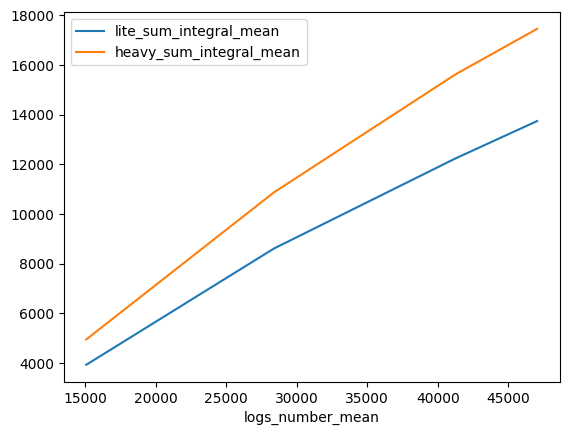

In [202]:
x.plot(x='logs_number_mean',y=['lite_sum_integral_mean', 'heavy_sum_integral_mean'], yerr=x[['lite_sum_integral_std', 'heavy_sum_integral_std']], capsize=40)

In [176]:
import altair as alt

# Melt the dataframe to long format
df_long = df_group.melt(id_vars=['duration', 'kind'])

# Define the base chart with faceting
base_chart = alt.Chart(df_long).mark_line(point=True).encode(
    alt.Y('value:Q', title='Mean and Standard Deviation'),
    alt.X('logs_number:Q'),
    alt.Color('kind:N'),
    facet=alt.Facet('stat:N', title=None, columns=2),
)

# Add error bars to each panel
error_bars_chart = base_chart.mark_errorbar().encode(
    y='value:Q',
    yError='stderr:Q',
)

# Calculate the standard error of the mean for each group
stderr = df_group.groupby(['duration', 'kind']).agg('std') / df_group.groupby(['duration', 'kind']).agg('count')

# Layer the error bars on top of the base chart
chart = (base_chart + error_bars_chart).transform_calculate(
    stderr=alt.datum['std'] / alt.datum['count']**0.5
).properties(
    title='Mean and Standard Deviation with Error Bars'
)

chart.show()


ValueError: Faceted charts cannot be layered.

<AxesSubplot:xlabel='logs_number'>

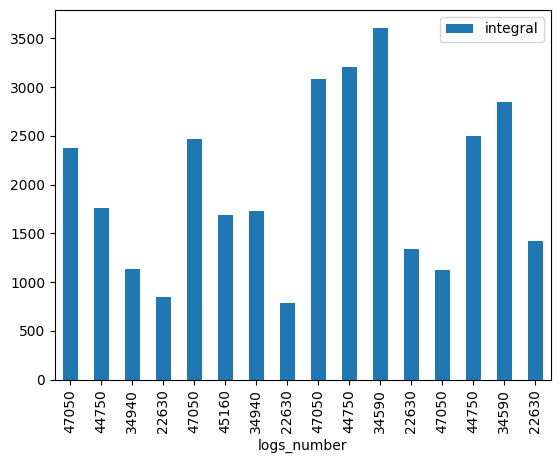

In [139]:
df.groupby(['duration','kind']).plot(x='logs_number', y='integral',kind='bar')

In [ ]:
import requests
from time import sleep

# Define the Splunk URL and login credentials
url = "https://132.72.81.185:8089/servicesNS/shoueii/splunkawssecuritymon/saved/searches/"
username = "shoueii"
password = "sH231294"

# Define the list of scheduled search names to enable/disable
searches_to_enable = ['aws_detect_cloudtrail_trail_deleted Clone1', 'aws_detect_cloudwatch_log_group_delete Clone1', 'aws_detect_cloudwatch_log_stream_delete Clone1', 'aws_detect_ec2_instances_run Clone1', 'aws_detect_ec2_vpc_flow_config_deleted Clone1', 'aws_detect_ecr_image_auth_token_get Clone1']
searches_to_disable = ['aws_detect_iam_user_deleted Clone', 'aws_detect_iam_user_created Clone', 'aws_detect_iam_new_policy_version_assignment Clone', 'aws_detect_iam_group_added_with_user_from_ec2 Clone', 'aws_detect_ecr_new_repo_image_create Clone', 'aws_detect_ec2_ssh_public_key_addition Clone']


for search_name in searches_to_enable:
    # Define the headers and payload for the request
    headers = {"Content-type": "application/json"}
    payload = {"disabled": 0}

    # Make the request to update the scheduled search
    response = requests.post(
        url + search_name + "/",
        headers=headers,
        auth=(username, password),
        data=payload,
        verify=False,
    )
    sleep(2)
    # Check the response status code
    if response.status_code == 200:
        print("Scheduled search updated successfully")
    else:
        print("Error updating scheduled search")
        print(response.content)
    

# Loop through the list of searches to disable and disable them
for search_name in searches_to_disable:
   # Define the headers and payload for the request
    headers = {"Content-type": "application/json"}
    payload = {"disabled": 1}

    # Make the request to update the scheduled search
    response = requests.post(
        url + search_name + "/",
        headers=headers,
        auth=(username, password),
        data=payload,
        verify=False,
    )

    # Check the response status code
    if response.status_code == 200:
        print("Scheduled search updated successfully")
    else:
        print("Error updating scheduled search")
        print(response.content)
    

/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Scheduled search updated successfully
Scheduled search updated successfully


/home/green-sec/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
